# EMSC 2021/4021/6021 Lab 5

### Due 2pm, Tuesday 31 October 2017

## ZEBRA
ZEBRA is a zonally averaged energy balance model of the Earth's climate system -- see the model documentation for a full description. In this lab, we're going to use ZEBRA to investigate a few key aspects of climate dynamics.

Before starting the questions below, you should familiarise yourself with the code and run some preliminary tests with different parameters so that you have an understanding of how the model behaves, and look at the default model output.

It's likely that to answer some of the questions below you will need to read in saved output from different model simulations and plot it. There is a sample plotting file included in the distribution, which can be adapted for this purpose.

The following 3 questions are open-ended -- I'm not specifying exactly which plots you need to make, I want to see you interpret the model and describe what this might say about the Earth's climate system.

1. **Climate Sensitivity:** What is the climate sensitivity of this model to, say, a doubling of CO$_2$, and doubling again? How long does it take to reach equilibrium? What else happens to the model climate while the warming occurs?
2. **Ice Ages:** During the last glacial, the Earth's obliquity and CO$_2$ were both lower (perhaps 22$^\circ$ and 180 ppm respectively). Vary these parameters, first independently and then together. What can you say about the models' representation of ice ages? You might like to also reduce ocean heat transport in the northern hemisphere to see if this has an effect.
3. **Alternative Realities:** Select a different continental configuration to investigate. You might consider a waterworld, a single continent over one of the poles, more landmass in equatorial regions, no ocean at all, etc. Highlight the differences between your alternatively configured Earth  and the present day, and explain why it behaves as it does. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import radfun as rad
import os

In [62]:
def cal_output(InitTemp,Obliquity, CO2, OceanFraction):
    # Model parameters -- the following can be altered to control model behaviour.
    RunTime = 100.0                 # Simulation length in years
    dt = (24.0*60.0*60.0)           # Timestep - in seconds (default is 1 day)
    OutputFreq = 1.0 				# Frequency of timeseries - default is 1 year
    SolarConstant = 1370.0          # Default: 1370.0
    AtmosK = 1.6                    # Diffusivity controlling atmos meridional heat transport
    OceanK = 0.021                  # Diffusivity controlling ocean meridional heat transport
    AtmosHeatCapacity = 1.2*1000.0*10000.0    # rho * Cp * H
    OceanHeatCapacity = 1000.0*3900.0*300.0   # rho * Cp * H, where H is mixed layer thickness
    
    # Set up domain - 5 degree grid spacing - best not to alter this:
    ny = 36
    Latitude = np.linspace(-87.5,87.5,ny)
    LatitudeFaces = np.linspace(-90,90,ny+1)
    
    # Some Fundamental Quantities:
    DegRad = np.pi/180
    SecsYr = 365*24.0*60.0*60.0
    
    # Derived quantities -- only change these if you think you know what you're doing!
    RunTimeSecs = RunTime*SecsYr
    OutputFreqSecs = OutputFreq*SecsYr
    nt = int(RunTimeSecs/dt)
    CellArea = np.cos(Latitude*DegRad)
    CellFaceLength = np.cos(LatitudeFaces*DegRad)
    dy = (Latitude[2] - Latitude[1])*DegRad*6.0e6
    
    # 1. Heat Capacity at each latitude
    HeatCapacity = OceanFraction*(OceanHeatCapacity + AtmosHeatCapacity) + (1-OceanFraction)*AtmosHeatCapacity
    
    # 2. Specify Atmosphere and Ocean diffusivity
    #    Includes diffusivity on cell faces for quantifying meridional heat flux
    #    Note that effective K includes heat capacity, and are in units of W/K 
    AtmosEffectiveK = AtmosK*AtmosHeatCapacity*np.ones(ny)
    OceanEffectiveK = OceanK*OceanHeatCapacity*np.ones(ny)
    TotalK = (OceanFraction*OceanEffectiveK + AtmosEffectiveK)
    CellFaceK = np.zeros(ny+1)
    CellFaceK[0:ny] = TotalK
    CellFaceK[1:ny+1] = 0.5*(CellFaceK[1:ny+1] + TotalK)
    
    # 3. Calculate Albedo
    OceanBaseAlbedo = 0.16 + 0.14*np.exp(-(Latitude/15.)**2.0)
    LandBaseAlbedo = 0.22 + 0.08*np.exp(-(Latitude/15.)**2.0)
    BaseAlbedo = OceanFraction*OceanBaseAlbedo + (1-OceanFraction)*LandBaseAlbedo
    
    # 4. Calculate Annually Averaged Insolation (not dynamic)
    Insolation = np.zeros(ny)
    for i in range(ny):
        Insolation[i] = SolarConstant*rad.AnnMeanFluxCirc(Latitude[i]*DegRad,Obliquity*DegRad)   

    ## Almost ready to timestep.
    #  Initialise Temperature 
    if np.isreal(InitTemp):
        SurfaceTemp = InitTemp*np.ones(ny)
        print ('   * Starting from globally constant initial condition %0.2f K' % InitTemp )
    else:
        SurfaceTemp = np.load(InitTemp)
        print ('   * Reading restart conditions from ' + InitTemp )
    
    ## Initialise timeseries diagnostics
    SPTemp = SurfaceTemp[0] 
    EqTemp = np.max(SurfaceTemp)
    NPTemp = SurfaceTemp[-1]
    GlobalTemp = np.sum(SurfaceTemp*CellArea)/np.sum(CellArea)
    Time = 0.0

    # Initialise variables.
    MeridionalFlux = np.zeros(ny+1)

    ## MAIN TIMESTEPPING LOOP
    ## Loop over nt timesteps
    for i in range(nt):
        ## Calculate outgoing radiation based on last timestep
        outgoing = rad.OLR(SurfaceTemp,CO2)
    
        ## Derive dynamic component of Albedo due to ice feedback
        Albedo = BaseAlbedo + (1.0-np.tanh(0.2*(SurfaceTemp-264)))/5.0
    
        ## Calculate heat fluxes
        MeridionalFlux[1:-1] = CellFaceLength[1:-1]*np.diff(SurfaceTemp)/dy
        DF = TotalK*np.diff(MeridionalFlux)/CellArea
    
        # Now timestep
        SurfaceTemp = SurfaceTemp + dt*( (1.0-Albedo)*Insolation - outgoing + DF)/HeatCapacity

        ## If we're on a multiple of OutputFreq then store data in timeseries
        if np.mod(i*dt,OutputFreqSecs)==0:
            SPTemp = np.append(SPTemp,SurfaceTemp[0])
            EqTemp = np.append(EqTemp,np.max(SurfaceTemp))
            NPTemp = np.append(NPTemp,SurfaceTemp[-1])
            GlobalTemp = np.append(GlobalTemp,np.sum(SurfaceTemp*CellArea)/np.sum(CellArea))
            Time = np.append(Time,i*dt/SecsYr)
    
        ## END OF TIMESTEPPING LOOP
    
    ## Print out some critical final details
    print (' ')
    print (' Some Points Regarding the Final State')
    print ('---------------------------------------')
    print ('   * Global Mean Temperature is %0.2f C' % (GlobalTemp[-1]-273.15) )
    print ('   * North Polar Temperature is %0.2f C' % (NPTemp[-1]-273.15) )
    print ('   * Tropical Temperature is %0.2f C' % (EqTemp[-1]-273.15) )
    print ('   * South Polar Temperature is %0.2f C' % (SPTemp[-1]-273.15) )
    print ('   * Globally Averaged Albedo is %0.2f' % (np.sum(Albedo*CellArea)/np.sum(CellArea)) )
    
    # Save current state for future use
    np.save('output/SurfaceTemp.npy',SurfaceTemp)
    
    # Also save everything else that I might need
    np.savez('output/all_run_data.npz', outgoing=outgoing, Albedo=Albedo, Insolation=Insolation, 
        Latitude=Latitude, CellFaceK=CellFaceK, MeridionalFlux=MeridionalFlux, LatitudeFaces=LatitudeFaces,
        OceanFraction=OceanFraction, SurfaceTemp=SurfaceTemp, Time=Time, EqTemp=EqTemp, NPTemp=NPTemp, SPTemp=SPTemp, GlobalTemp=GlobalTemp)
    
    plt.figure(1,(12,10))
    plt.subplot(231)
    plt.plot(outgoing,Latitude,(1-Albedo)*Insolation,Latitude,'r--')
    plt.ylabel('Latitude')
    plt.xlabel('Radiation')
    plt.ylim([-90,90])
    plt.legend(['OLR','Net Insolation'],loc=6)
    plt.title('Radiative Terms (W/m**2)')
    
    plt.subplot(232)
    plt.plot(-CellFaceK*MeridionalFlux,LatitudeFaces)
    plt.ylim([-90,90])
    plt.title('Meridional Heat Flux (W/m**2)')
    
    plt.subplot(233)
    plt.plot(SurfaceTemp - 273.15,Latitude)
    plt.ylim([-90,90])
    plt.title('Temperature (C)')
    
    plt.subplot(234)
    plt.plot(Albedo,Latitude,OceanFraction,Latitude,'r--')
    plt.ylabel('Latitude')
    plt.ylim([-90,90])
    plt.legend(['Albedo','Ocean'],loc=7)
    plt.title('Albedo, Ocean Fraction')
    
    plt.subplot(224)
    plt.plot(Time,EqTemp- 273.15,Time,NPTemp- 273.15,Time,SPTemp- 273.15,Time,GlobalTemp- 273.15)
    plt.xlabel('Time (yrs)')
    plt.ylabel('Temperature (C)')
    plt.title('Evolution of model temperature')
    plt.legend(['Equator','North Pole','South Pole','Global Mean'],loc=7)
    
    return

1. **Climate Sensitivity:**

1.1 What is the climate sensitivity of this model to, say, a doubling of CO$_2$, and doubling again?

1.2 How long does it take to reach equilibrium?

1.3 What else happens to the model climate while the warming occurs?

### Result summary and answers for question 1:
#### Climate sensitivity for the first, second, third doubling is listed in the following table, the code and details are explain below.
| CO$_2$ (ppm)| Initial Temperature | Global mean temp|North Pole Temp|South Pole Temp|Tropical Temp|Global mean albedo|
|---------|---------|---------|---------|---------|---------|---------|
|280 |0 $^\circ$C|14.73 $^\circ$C|-18.71 $^\circ$C|-19.4 $^\circ$C|25.76 $^\circ$C|0.24|
|560 |14.73 $^\circ$C|19.86 $^\circ$C|-5.52 $^\circ$C|-8.62 $^\circ$C|29.38 $^\circ$C|0.21|
|1120|19.86 $^\circ$C|22.49 $^\circ$C|-2.69 $^\circ$C|-4.51 $^\circ$C|31.97 $^\circ$C|0.21|

According to outputs below, it takes around 90 years to reach equilibrium for the first doubling of CO$_2$. The second doubling takes approximately 60 years, while the third doubling takes about 40 years.

This result infers that the global warning also impact globally averaged Albedo. The globally averaged Albedo decreases due to warning caused by CO$_2$ concentrtion. It is possible that warning enhanced ice-melting and ice cover reduction induce the reduction in Albedo. 


#### 1.1.1 The initial CO$_2$ is 280.0 ppm and starting temperature is 0.0 $^\circ$C (273.15 K). 

#### With a doubling of CO$_2$ to 560.0 ppm, the final global mean temperature is 14.73 $^\circ$C (287.88 K).

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 14.73 C
   * North Polar Temperature is -18.71 C
   * Tropical Temperature is 25.76 C
   * South Polar Temperature is -19.40 C
   * Globally Averaged Albedo is 0.24


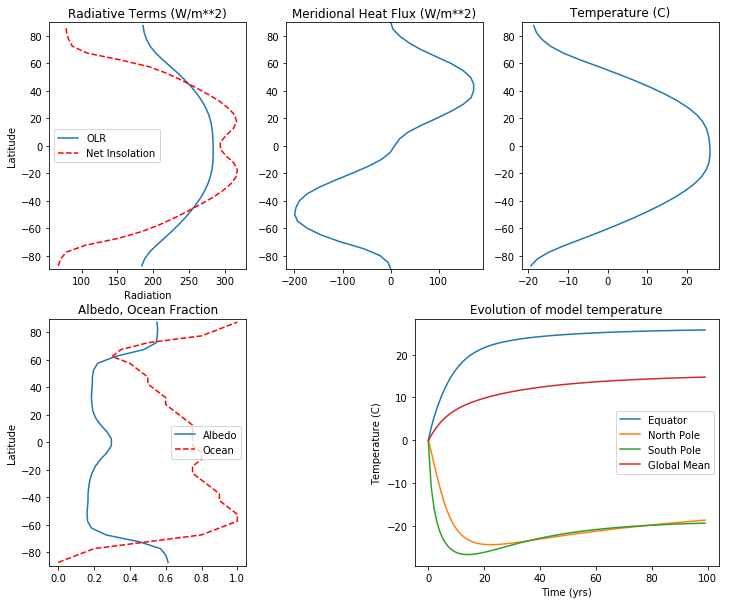

In [63]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 280.0                     # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### 1.1.2 The initial CO$_2$ changes to 560.0 ppm and starting temperature is 14.73 $^\circ$C (287.88 K). 

#### With a doubling of CO$_2$ to 1120.0 ppm, the final global mean temperature is 19.86 $^\circ$C (293.01 K).

   * Starting from globally constant initial condition 287.88 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 19.86 C
   * North Polar Temperature is -5.52 C
   * Tropical Temperature is 29.38 C
   * South Polar Temperature is -8.62 C
   * Globally Averaged Albedo is 0.21


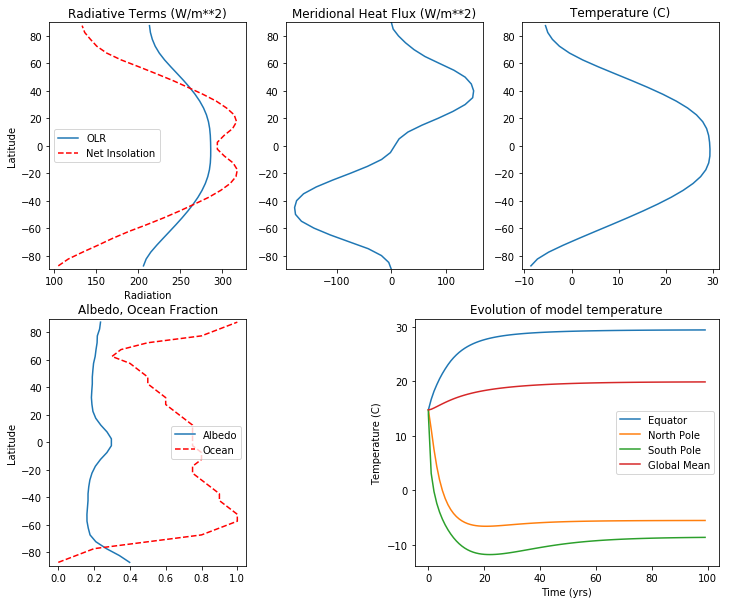

In [64]:
InitTemp = 287.88               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 560.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### 1.1.3 The initial CO$_2$ changes to 560.0 ppm and starting temperature is 19.86 $^\circ$C (293.01 K). 

#### With a doubling of CO$_2$ to 1120.0 ppm, the final global mean temperature is 22.49 $^\circ$C (295.64 K).

   * Starting from globally constant initial condition 293.01 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 22.49 C
   * North Polar Temperature is -2.69 C
   * Tropical Temperature is 31.97 C
   * South Polar Temperature is -4.51 C
   * Globally Averaged Albedo is 0.21


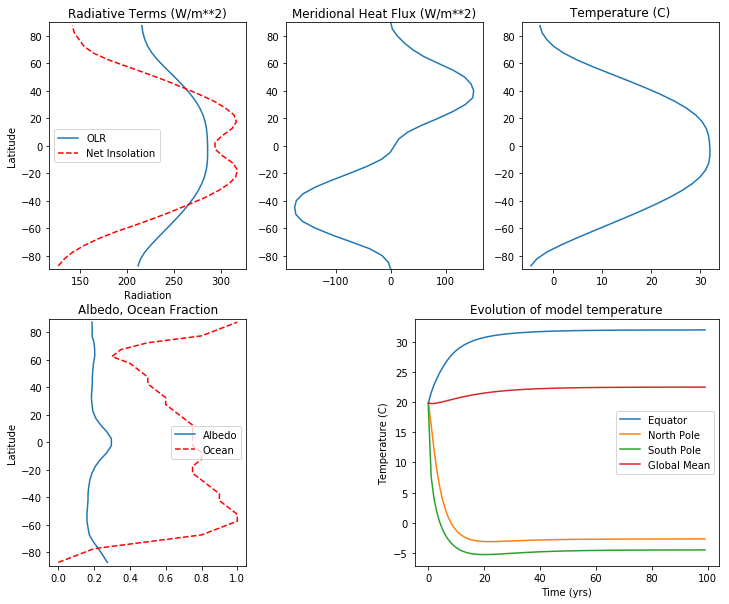

In [65]:
InitTemp = 293.01               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 1120.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

### Qustion 2

###### 2. **Ice Ages:** During the last glacial, the Earth's obliquity and CO$_2$ were both lower (perhaps 22$^\circ$ and 180 ppm respectively). Vary these parameters, first independently and then together. 

What can you say about the models' representation of ice ages? 

You might like to also reduce ocean heat transport in the northern hemisphere to see if this has an effect.

#### Result summary and Answers for question 2:

The reference group in this question is the present Earth's obliquity and CO$_2$ (23.5 $^\circ$ and 280 ppm respectively).

I vary the Earth obliquity and CO$_2$ first independently and then together to achieve following results.

| CO$_2$ (ppm)|Obliquity| Initial Temp | Global mean temperature|North Pole Temp|South Pole Temp|Tropical Temp| Global mean albedo|
|---------|---------|---------|---------|---------|---------|---------|---------|
|280|23.5$^\circ$|0$^\circ$C|14.73$^\circ$C|-18.71$^\circ$C|-19.4$^\circ$C|25.76$^\circ$C|0.24|
|280|22.0$^\circ$|0$^\circ$C|14.19$^\circ$C|-21.34$^\circ$C|-21.28$^\circ$C|25.91$^\circ$C|0.24|
|180|23.5$^\circ$|0$^\circ$C|11.58$^\circ$C|-25.10$^\circ$C|-22.78$^\circ$C|23.60$^\circ$C|0.25|
|280|23.5$^\circ$|0$^\circ$C|11.35$^\circ$C|-26.31$^\circ$C|-24.17$^\circ$C|23.85$^\circ$C|0.26|

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 14.19 C
   * North Polar Temperature is -21.34 C
   * Tropical Temperature is 25.91 C
   * South Polar Temperature is -21.28 C
   * Globally Averaged Albedo is 0.24


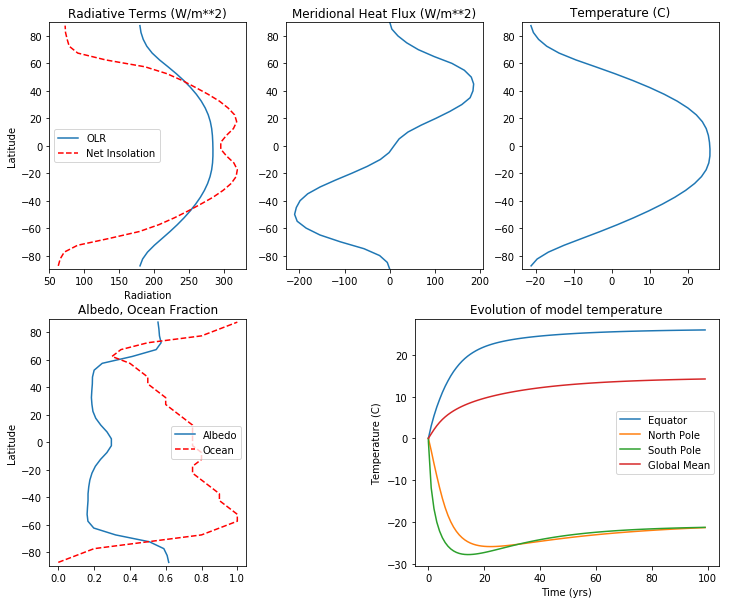

In [66]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 22.0                # Default: 23.5
CO2 = 280.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 11.58 C
   * North Polar Temperature is -25.10 C
   * Tropical Temperature is 23.60 C
   * South Polar Temperature is -22.78 C
   * Globally Averaged Albedo is 0.25


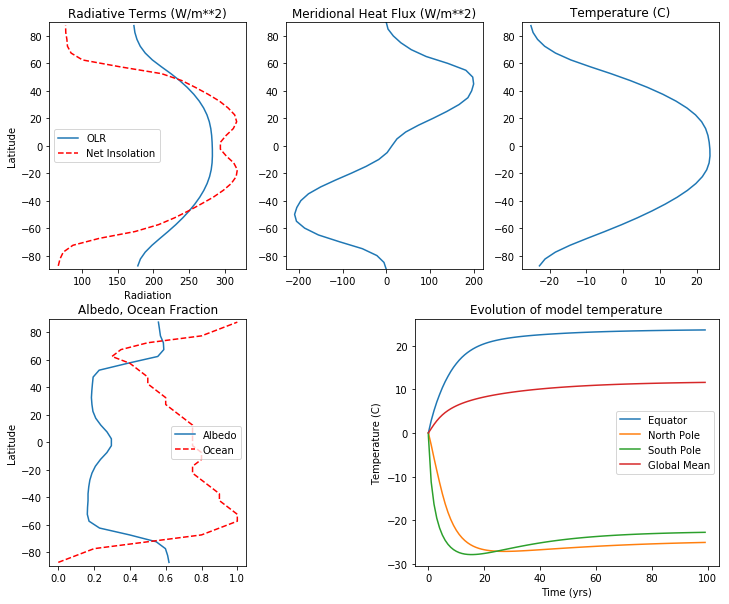

In [67]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 180.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 11.35 C
   * North Polar Temperature is -26.31 C
   * Tropical Temperature is 23.85 C
   * South Polar Temperature is -24.17 C
   * Globally Averaged Albedo is 0.26


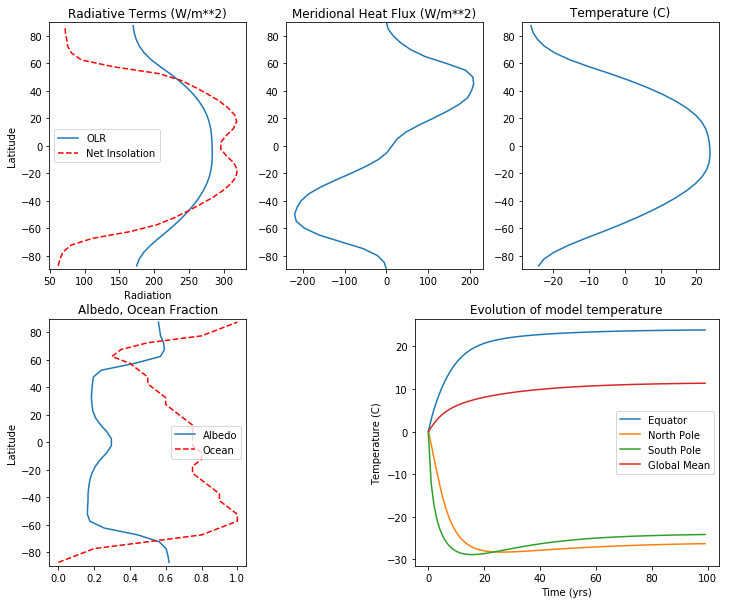

In [68]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 22.0                # Default: 23.5
CO2 = 180.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.array([ 0. ,  0.1 ,  0.2,  0.5,  0.8,  0.9, 1.0,  1.0,  0.95,  0.9,  0.9,  
                          0.85, 0.8,  0.75,  0.75,  0.8,  0.8,  0.75,  0.75,  0.75,  0.75,  
                          0.7,  0.65,  0.6, 0.6,  0.55,  0.5,  0.5,  0.45,  0.4, 0.3,  
                          0.35,  0.5, 0.8,  0.9,  1.0])      # Based on Roderick & Lim (2009) 
cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### Answer:
This model shows a strong correlation between temperature and CO2 concentration. With the same obliquity, the global mean temperature increases by 2.84 K (25%) from the Ice Ages to the interglacier period. The North Pole has increased the most by 4.97 K, while the South pole and tropical areas rised up by 2.89 K and 2.06 K respectively. 

### Question 3:

**Alternative Realities:** Select a different continental configuration to investigate. You might consider a waterworld, a single continent over one of the poles, more landmass in equatorial regions, no ocean at all, etc. Highlight the differences between your alternatively configured Earth  and the present day, and explain why it behaves as it does. 

The initial CO$_2$ and temperatures are the same, 280ppm and 0 $^\circ$C respectively. The obliquity is 23.5 $^\circ$.

|Configuration| Global mean temperature|North Pole Temp|South Pole Temp|Tropical Temp| Global mean albedo|
|---------|---------|---------|---------|---------|---------|---------|---------|
|Water World|21.01$^\circ$C|0.51$^\circ$C|0.51$^\circ$C|28.64$^\circ$C|0.19|
|no ocean|-1.75$^\circ$C|-48.21$^\circ$C|-48.21$^\circ$C|20.93$^\circ$C|0.38|
|single continent at south pole|14.98$^\circ$C|-0.16$^\circ$C|-33.76$^\circ$C|26.18$^\circ$C|0.23|
|continent at equator|21.56$^\circ$C|0.79$^\circ$C|0.83$^\circ$C|29.47$^\circ$C|0.19|

#### 3.1 Waterworld

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 21.01 C
   * North Polar Temperature is 0.51 C
   * Tropical Temperature is 28.64 C
   * South Polar Temperature is 0.51 C
   * Globally Averaged Albedo is 0.19


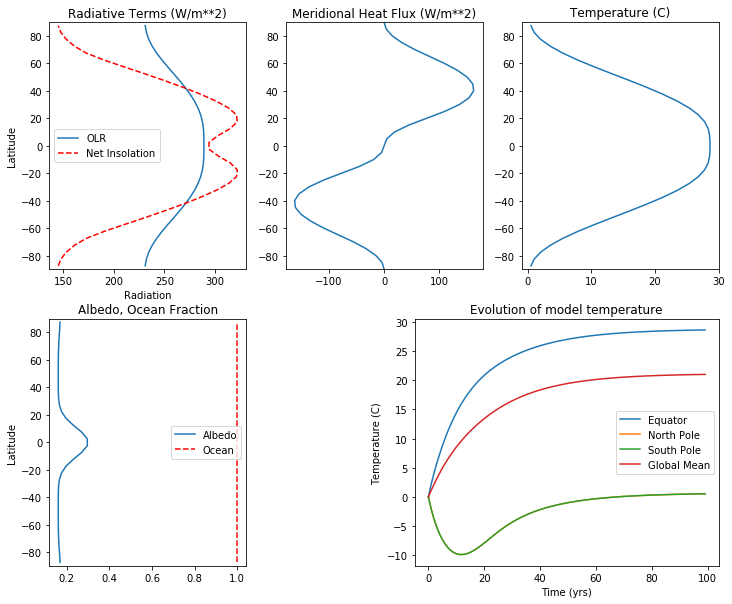

In [73]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 280.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.ones(36)

cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### 3.2 no ocean

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is -1.75 C
   * North Polar Temperature is -48.21 C
   * Tropical Temperature is 20.93 C
   * South Polar Temperature is -48.21 C
   * Globally Averaged Albedo is 0.38


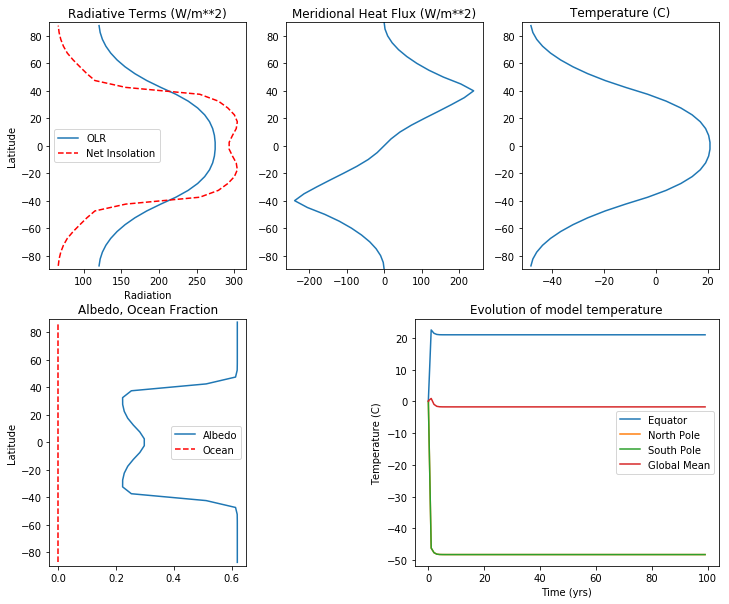

In [74]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 280.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.zeros(36)

cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### 3.3 single continent at south pole

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 14.98 C
   * North Polar Temperature is -0.16 C
   * Tropical Temperature is 26.18 C
   * South Polar Temperature is -33.76 C
   * Globally Averaged Albedo is 0.23


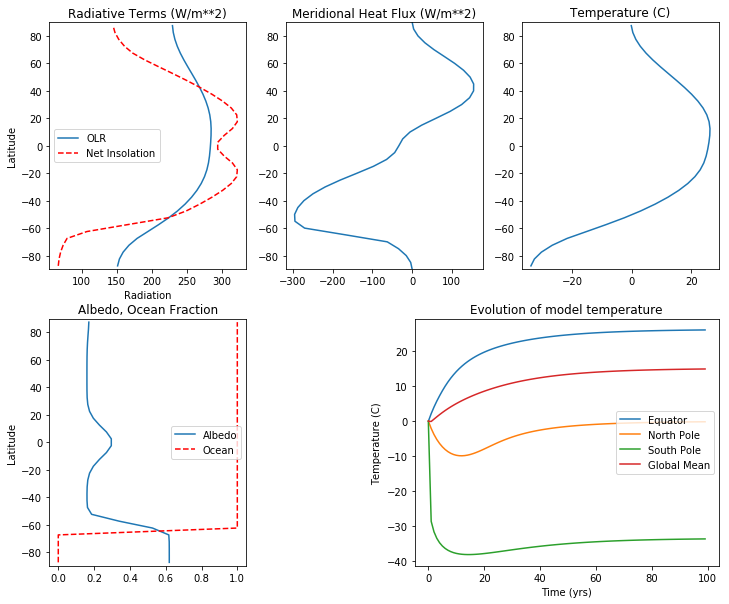

In [75]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 280.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.ones(36)
OceanFraction[0:5]=0

cal_output(InitTemp,Obliquity, CO2, OceanFraction)

#### 3.4 major continent at equator

   * Starting from globally constant initial condition 273.15 K
 
 Some Points Regarding the Final State
---------------------------------------
   * Global Mean Temperature is 21.56 C
   * North Polar Temperature is 0.79 C
   * Tropical Temperature is 29.47 C
   * South Polar Temperature is 0.83 C
   * Globally Averaged Albedo is 0.19


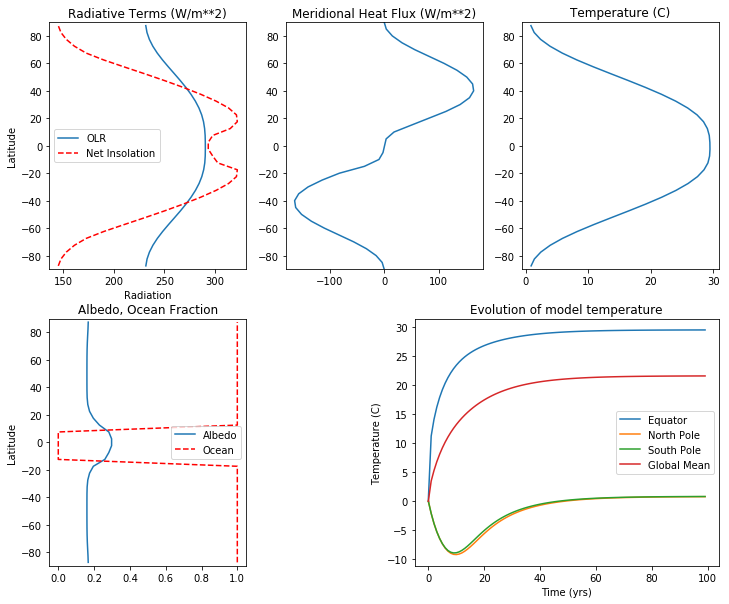

In [78]:
InitTemp = 273.15               # Could be filename '*.npy' or constant value.
Obliquity = 23.5                # Default: 23.5
CO2 = 280.0                    # Default is preindustrial, 280.0 ppm
OceanFraction = np.ones(36)
OceanFraction[15:20]=0

cal_output(InitTemp,Obliquity, CO2, OceanFraction)

<Type your answer to 1 here>